<div align="center">

# Social Graphs and Interactions 02805


## Assignment 2


#### Group 67

**Made By:**  
Nicklas Thorvald Kiær, s216137\
Alexander Vaaben, s214958\
Oliver Brandt-Olsen, s216162


*4/11/2025*

---

</div>


Note: To run the code, please place "artists" directory at same location as the script, along with the file "labMT.txt" both can be found on the \
github repo:
<url>https://github.com/Nicklaskiaer/social-graphs-assignments/tree/main/assignment_2</url>

## Part 1 - Analyze the network

For this part of the assignement, the network is initially created the same way it was for assignment 1. Whereafter the analysis is performed.

In [23]:
import os
import re
import networkx as nx
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statistics import mean, median, mode, StatisticsError
from collections import Counter, defaultdict
from typing import Optional, List, Dict, Iterable, Tuple
import random
import matplotlib.patheffects as pe
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
import csv

In [2]:
# get artists from dataset
artist_dir = 'artists'
artist_files = [f for f in os.listdir(artist_dir) if f.endswith('.txt')]
artist_names = [os.path.splitext(f)[0] for f in artist_files]
artist_set = set(artist_names)

G = nx.DiGraph()
G.add_nodes_from(artist_names)

wiki_url_pattern = re.compile(r'https?://en\.wikipedia\.org/wiki/([^\s\]#]+)')


for filename in artist_files:
    artist = os.path.splitext(filename)[0]
    filepath = os.path.join(artist_dir, filename)
    with open(filepath, 'r', encoding='utf-8') as f:
        wikitext = f.read()

    # Find all internal wiki links
    links = re.findall(r'\[\[(.*?)\]\]', wikitext)
    for link in links:
        target = link.split('|')[0].strip().replace('/', '_').replace(' ', '_')
        if target in artist_set and target != artist:
            G.add_edge(artist, target)

print(f"Directed graph: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

# remove inactive nodes, and node: AllMusic and node: rock_music
active_nodes = [node for node in G.nodes() if G.degree(node) > 0]

G_clean = G.subgraph(active_nodes).copy()
G_clean.remove_nodes_from(["rock_music", "AllMusic"])


Directed graph: 490 nodes, 7943 edges


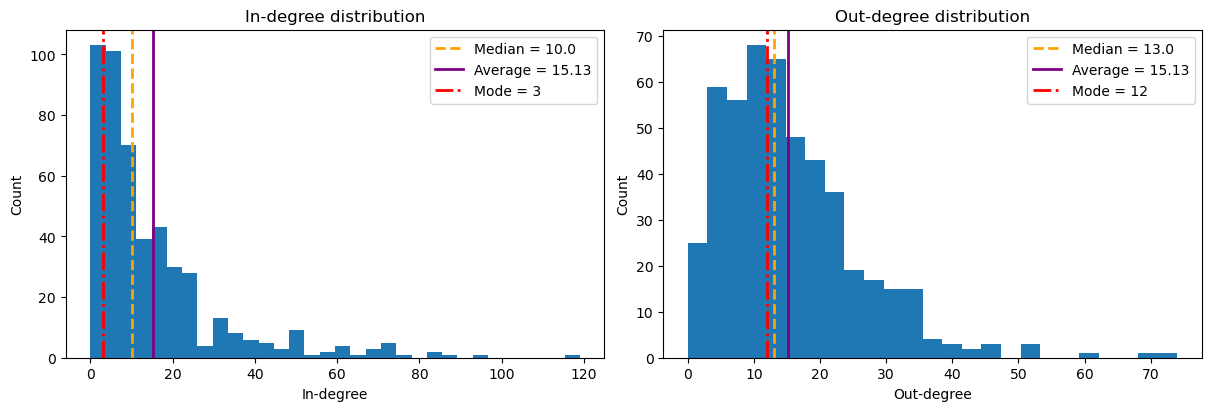

In [3]:
node_names = list(G_clean.nodes())
in_deg_dict = dict(G_clean.in_degree())
out_deg_dict = dict(G_clean.out_degree())
in_degrees = [in_deg_dict[n] for n in node_names]
out_degrees = [out_deg_dict[n] for n in node_names]


def describe_degree(degrees):
    avg = mean(degrees)
    med = median(degrees)
    try:
        mod = mode(degrees)
    except StatisticsError:
        mod = "No unique mode"
    min_val = min(degrees)
    max_val = max(degrees)
    return avg, med, mod, min_val, max_val

in_avg, in_med, in_mod, in_min, in_max = describe_degree(in_degrees)
out_avg, out_med, out_mod, out_min, out_max = describe_degree(out_degrees)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), constrained_layout=True)

# In-degree histogram
axes[0].hist(in_degrees, bins='auto')
axes[0].axvline(in_med, linestyle='--', linewidth=2, label=f"Median = {in_med:.1f}", color='orange')
axes[0].axvline(in_avg, linestyle='-', linewidth=2, label=f"Average = {in_avg:.2f}", color='purple')
axes[0].axvline(in_mod, linestyle='-.', linewidth=2, label=f"Mode = {in_mod}", color='red')
axes[0].set_title("In-degree distribution")
axes[0].set_xlabel("In-degree")
axes[0].set_ylabel("Count")
axes[0].legend()

# Out-degree histogram
axes[1].hist(out_degrees, bins='auto')
axes[1].axvline(out_med, linestyle='--', linewidth=2, label=f"Median = {out_med:.1f}", color='orange')
axes[1].axvline(out_avg, linestyle='-', linewidth=2, label=f"Average = {out_avg:.2f}", color='purple')
axes[1].axvline(out_mod, linestyle='-.', linewidth=2, label=f"Mode = {out_mod}", color='red')
axes[1].set_title("Out-degree distribution")
axes[1].set_xlabel("Out-degree")
axes[1].set_ylabel("Count")
axes[1].legend()

plt.show()

### Interpretation of Degree Statistics

Both in- and out-degree distributions are **right-skewed** (meaning the average is larger than the median). This means a few artists have very high connectivity while most have lower degrees. However the difference it more pronounced in the *in-degree*

The **mode** values show that most artists link out to many others (out-degree mode = 12), but are not linked to as often (in-degree mode = 3). This fits with how Wikipedia pages usually are written. Band pages typically may mention a lot of other artists as influences, but only a small number of highly influential bands get referenced by many others.

The maximum **in-degree** (119) is higher than the maximum **out-degree** (74), again indicating the presence of strong “hub” nodes, as in, artists that many other pages point to.

In the next part, we will take a look at the degree centrality fo the network, to gain a stronger understanding of the top players in the network. 

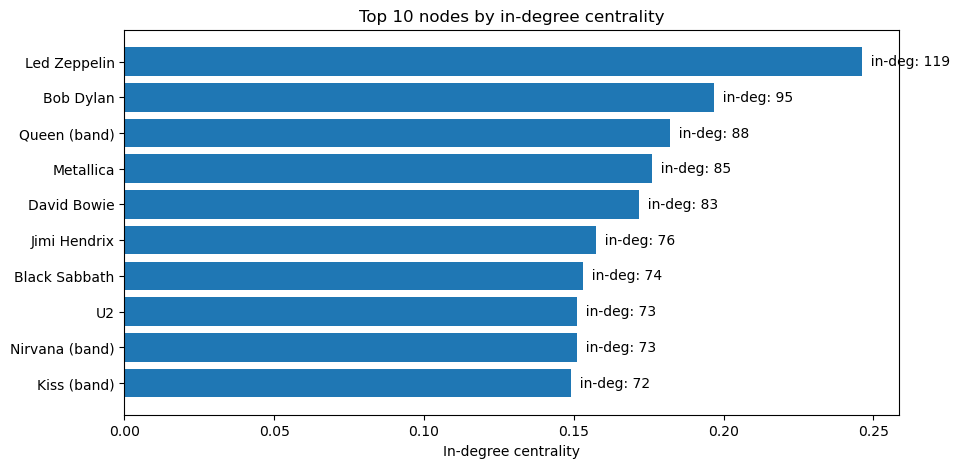

In [4]:
in_centrality = nx.in_degree_centrality(G_clean)

top_n = min(10, len(in_centrality))
top_nodes = sorted(in_centrality.items(), key=lambda item: item[1], reverse=True)[:top_n]

names = [n for n, c in top_nodes]
names_pretty = [n.replace('_', ' ') for n in names]
centralities = [c for n, c in top_nodes]
indegs = [dict(G_clean.in_degree()).get(n, 0) for n in names]

fig, ax = plt.subplots(figsize=(10, 5))
y_pos = np.arange(len(names))
ax.barh(y_pos, centralities)
ax.set_yticks(y_pos, labels=names_pretty)
ax.invert_yaxis()
ax.set_xlabel("In-degree centrality")
ax.set_title("Top 10 nodes by in-degree centrality")

# annotate in-degree on bars
for i, (val, indeg) in enumerate(zip(centralities, indegs)):
    ax.text(val, i, f"  in-deg: {indeg}", va='center')

plt.show()

### In-Degree Centrality Interpretation

The **in-degree centrality** measures the amount of links that point to a node, and in this case, the amount of rock bands that reference a specific other rock band in thier wiki article. 

We can see from printing the top 10 artists in order of **in-degree centrality** that these are all wvery well know, respected, and (most importantly) influencial rock bands. 

The top one being *Led Zeppelin*, who are linked to by a whopping 24% of the entire rock band network. And by reading up on them on thier wiki page, it is easy to see why. They are widely known for having placed thier mark on the rock music world. Being active from around 1970 to 1980. They had 10 years of influencing the genre. And were even inducted in the *Rock and Roll Hall of Fame* in 1995. 

This shows how influencial the band is, and therefore this also aligns with them being the most linked-to rock band on other rock band wikipedia pages.


Another aspect worth noting is the amount of different sub-genres being represented in the top 10 list. We see bands like *Metallica* which are known for being more of a **heavy metal** band. As well as Bob Dylan, who somie may say leans more into the **folk** genre. This further shows how broad and wide spanning the rock genre as a whole is. But more importantly, it shows how these bands that are often refered to as the "fathers" of thier genre, have had the influence in the real world, but also through thier wikipedia reach. They are all "pillars" in thier genre, and are also hubs in the wikipedia rock band network. 

Next, we will take a look into the assortativity of the newtork. 

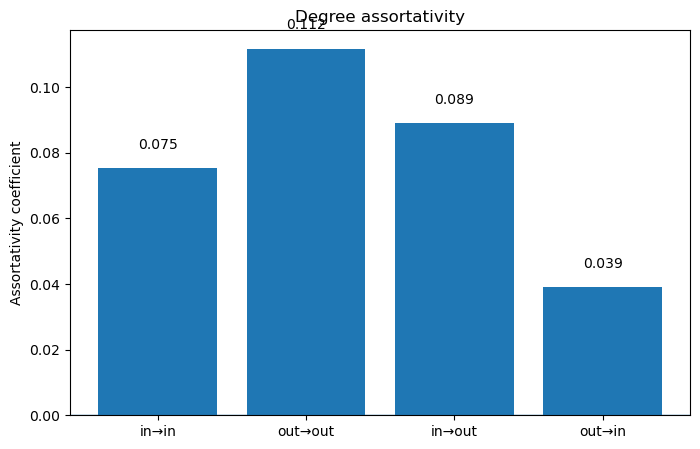

In [5]:
in_assortativity = nx.degree_assortativity_coefficient(G_clean, x='in', y='in')
out_assortativity = nx.degree_assortativity_coefficient(G_clean, x='out', y='out')
in_out_assortativity = nx.degree_assortativity_coefficient(G_clean, x='in', y='out')
out_in_assortativity = nx.degree_assortativity_coefficient(G_clean, x='out', y='in')

labels = ["in→in", "out→out", "in→out", "out→in"]
values = [in_assortativity, out_assortativity, in_out_assortativity, out_in_assortativity]

fig, ax = plt.subplots(figsize=(8, 5))
x = np.arange(len(labels))
ax.bar(x, values)
ax.axhline(0, linewidth=1)
ax.set_xticks(x, labels)
ax.set_ylabel("Assortativity coefficient")
ax.set_title("Degree assortativity")
for i, v in enumerate(values):
    ax.text(i, v + (0.005 if v >= 0 else -0.015), f"{v:.3f}", ha='center', va='bottom' if v >= 0 else 'top')
plt.show()

### Assortativity Interpretation

We see that all of the assortativity values are close to 0, but slightly positive. This suggests that the network is *weakly assortative*. Meaning that there is a slight tendency for some nodes with similar degrees, to link to eachother. But the effect is not really that strong. 

The strongest value of teh four is the **Out-degree assortativity** which is 0.1118, even this is still a pretty weak tendency, but it is nontheless still a tendency, for the pages which link out to many artists, to link to other pages that similarily also link out to many artists. 

The **in -> out** and **out -> in** are both very close to 0, indicating that hubs do not have a tendency to connected to other hubs. No matter if they are *influencial hubs* or *influenced hubs*.

This all counts towards the network being classified more as a neutral mixing of  nodes, than one categorized by importance in influenciality. 

/var/folders/rl/t5dv0yl50_v6ldwq8txtwk7h0000gn/T/ipykernel_12477/374506357.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


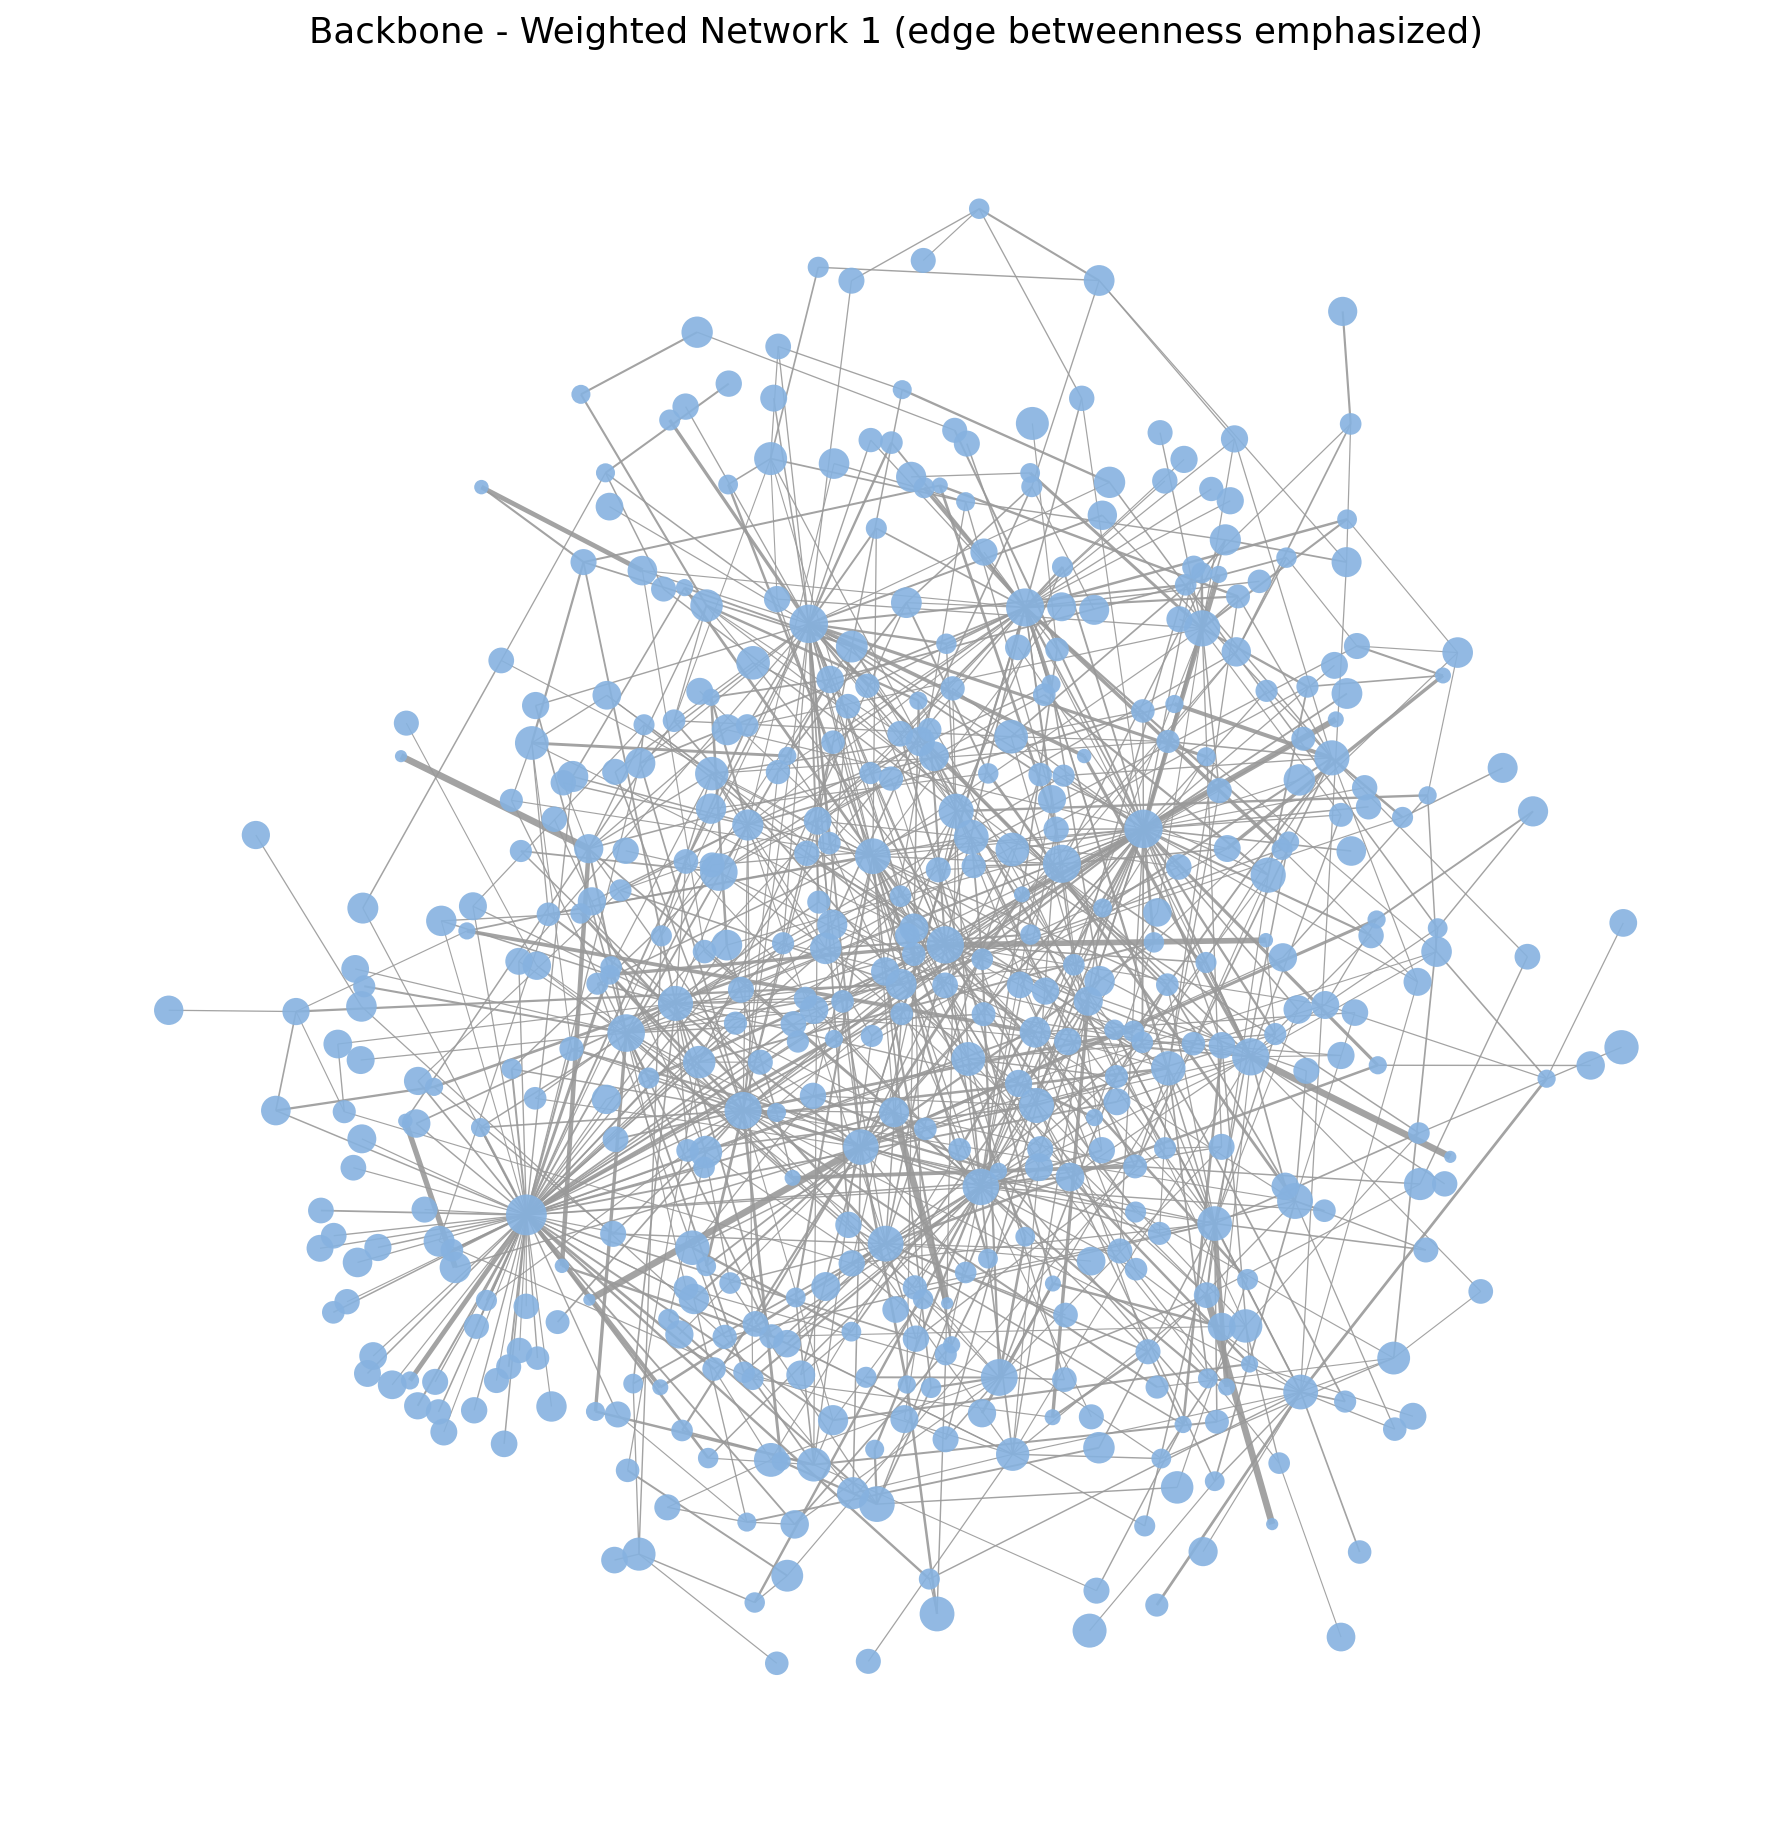

In [6]:

# get the undirected giant component
G_und = G_clean.to_undirected()
Gcc = max(nx.connected_components(G_und), key=len)
G_lcc = G_und.subgraph(Gcc).copy()

# helper: degree-based node sizes (total degree in G_lcc)
node_sizes = {n: 30 * np.sqrt(max(1, G_lcc.degree(n))) for n in G_lcc.nodes()}  # sqrt scaling looks better

# ---------- 1) Edge betweenness and the two weighted variants ----------
eb = nx.edge_betweenness_centrality(G_lcc, normalized=True)

# normalize to [1,100]
vals = np.array(list(eb.values()))
w1 = {e: 1 + 99 * ((eb[e] - vals.min()) / (vals.max() - vals.min() + 1e-12)) for e in G_lcc.edges()}
w2 = {e: 1.0 / w for e, w in w1.items()}

G_w1 = G_lcc.copy(); nx.set_edge_attributes(G_w1, w1, "weight")
G_w2 = G_lcc.copy(); nx.set_edge_attributes(G_w2, w2, "weight")

# ---------- 2) Use `backboning` to extract backbones ----------

def nx_to_table(G):
    # backboning expects a table; we'll use columns i, j, w
    rows = [(u, v, float(G[u][v].get("weight", 1.0))) for u, v in G.edges()]
    return pd.DataFrame(rows, columns=["i", "j", "w"])

def table_to_nx(table):
    H = nx.Graph()
    H.add_weighted_edges_from(table[["i","j","w"]].itertuples(index=False, name=None))
    return H


# backbone with high edge betweenness
t1 = nx_to_table(G_w1)
thr = t1["w"].quantile(1 - 0.15)
t1_bb = t1[t1["w"] >= thr]
G_bb1 = table_to_nx(t1_bb)


# ---------- 3) Plot with ForceAtlas2; size by total degree ----------
def plot_backbone(G_backbone, title):
    # drop isolates (optional)
    H = G_backbone.copy()
    H.remove_nodes_from([n for n in H.nodes() if H.degree(n) == 0])

    # ForceAtlas2 layout
    pos = nx.forceatlas2_layout(
        H,
        seed=42,
        max_iter=1000,
        gravity=1.25,
        jitter_tolerance=0.02,
        scaling_ratio=2.5,
    )

    sizes = [node_sizes.get(n, 6) for n in H.nodes()]
    widths = [H[u][v].get("weight", 1.0) for u, v in H.edges()]
    # rescale edge widths for visibility across variants
    if len(widths):
        w = np.array(widths, dtype=float)
        w = 0.5 + 2.5 * (w - w.min()) / (w.max() - w.min() + 1e-12)
        widths = w.tolist()

    plt.figure(figsize=(11, 11), dpi=160)
    nx.draw(
        H, pos,
        node_size=sizes,
        node_color="#86b2e0",
        edge_color="#999999",
        width=widths,
        alpha=0.9,
        with_labels=False,
        linewidths=0.0,
    )
    plt.title(title, fontsize=16)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_backbone(G_bb1, "Backbone - Weighted Network 1 (edge betweenness emphasized)")



The plot above shows the undirected giant component of the rock band network, where node size is proportional to degree. Even though the layout looks dense and chaotic, some structure is clearly visible: a handful of larger nodes are centrally positioned and connected to many smaller peripheral nodes. These large nodes represent highly referenced artists (hubs), while the outer layers are populated by smaller, more niche artists. The star-like “spokes” around some of the hubs also visually confirm the right-skew we saw in the degree statistics: a small number of artists accumulate far more connections than the average. Overall, the graph has a global core with dense cross-connections, surrounded by loose local clusters at the edges.




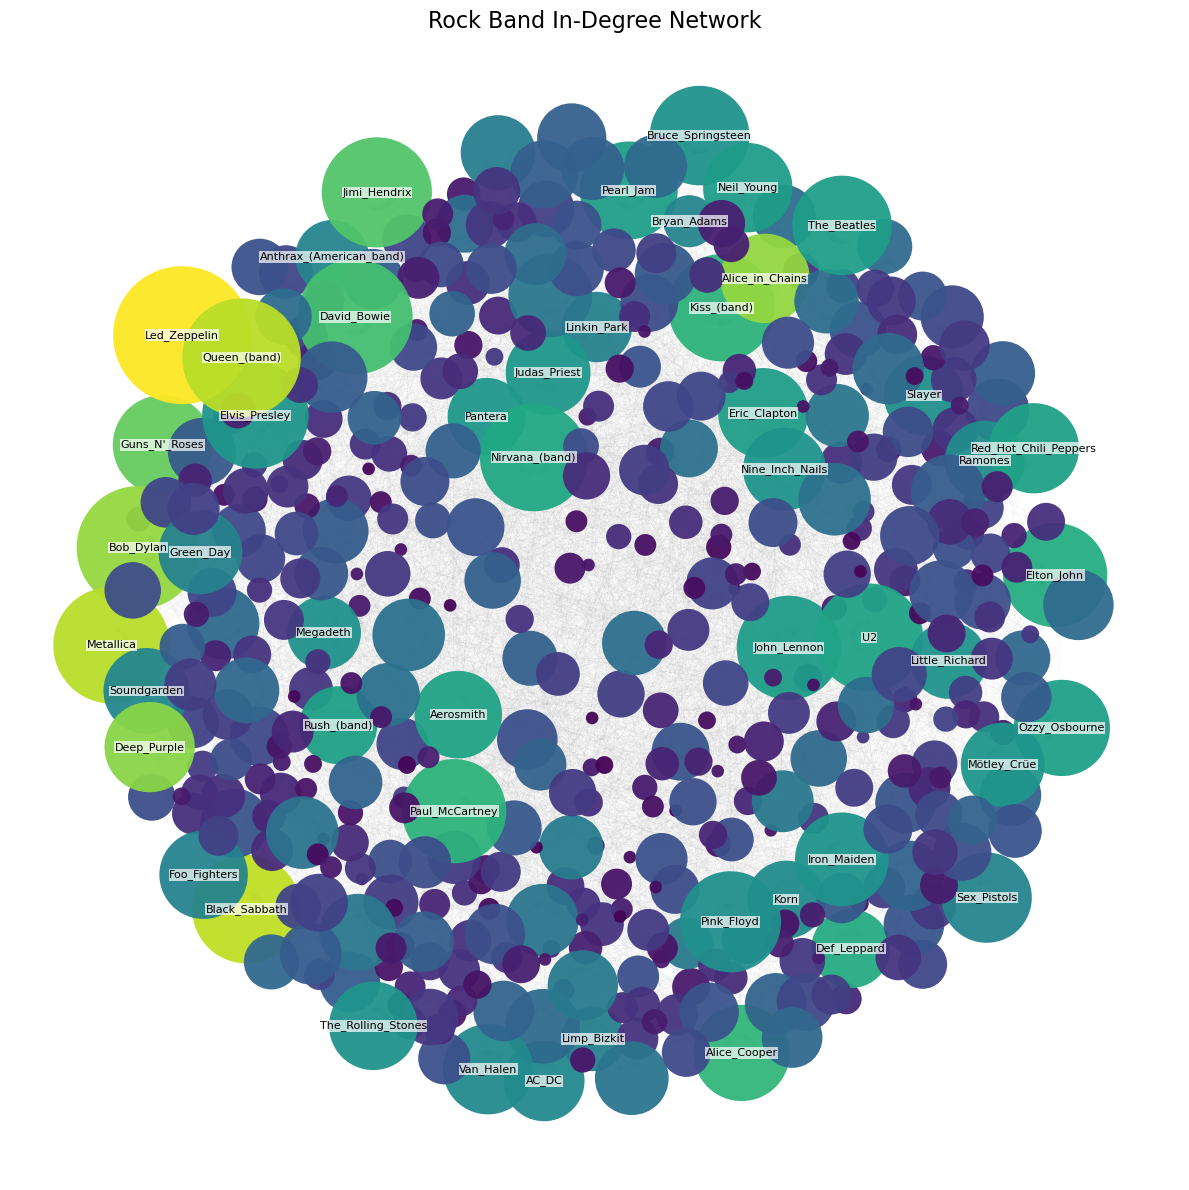

In [7]:
pos = nx.forceatlas2_layout(
    G_clean, 
    node_size=in_centrality, 
    seed=42,
    max_iter=1000, 
    gravity=1.5,           
    jitter_tolerance=0.02, 
    scaling_ratio=2.8,     
)

# scaling this up for visibility
node_sizes = [40000 * in_centrality[n] for n in G_clean.nodes()]

# color the nodes depending on thne degree
deg_dict = dict(G_clean.degree())
node_degrees = [deg_dict[n] for n in G_clean.nodes()]

# only show the top 50
top_nodes = sorted(deg_dict, key=deg_dict.get, reverse=True)[:50]
labels = {n: n for n in top_nodes}

plt.figure(figsize=(12, 12), dpi=100)

# draw edges faintly for less clutter
nx.draw_networkx_edges(
    G_clean, pos,
    width=0.25,
    alpha=0.05,
    edge_color="gray",
)

nx.draw_networkx_nodes(
    G_clean, pos,
    node_size=node_sizes,
    node_color=node_degrees,
    cmap=plt.cm.viridis,
    alpha=0.95,
    linewidths=0.0,
)

nx.draw_networkx_labels(
    G_clean, pos,
    labels=labels,
    font_size=8,
    font_color="black",
    bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=0.2),
)

plt.title("Rock Band In-Degree Network", fontsize=16)
plt.axis("off")
plt.tight_layout()
plt.show()


The above visualisation of the network is created using forceatlas2, which is an algorithm that creates the positions for the nodes based on "physics". Simply put, it makes nodes converge into more fitting positions through multiple iterations. 

The nodes are sized according to the in-degree of it, as well as colored according to the general degree of the node. We can see again how the influencial, older rock bands are larger, and brighter. Thereby visually showing how much influence a few bands have had on the entire genre. 

## Part 2

=== Genre Extraction Stats (from G) ===
Nodes with genres: 480
Average number of genres per node: 3.05
Total number of distinct genres: 200

Top genres (artist counts):
  alternative rock: 124
  hard rock: 115
  pop rock: 79
  alternative metal: 58
  rock: 51
  heavy metal: 46
  post-grunge: 42
  pop: 38
  blues rock: 35
  soft rock: 29
  punk rock: 26
  power pop: 26
  progressive rock: 26
  indie rock: 25
  nu metal: 24


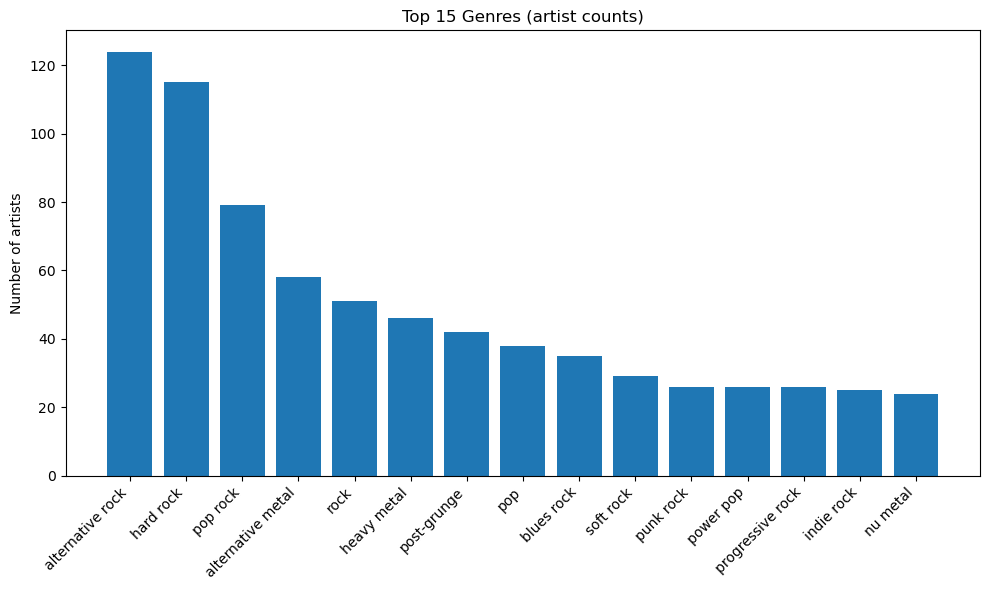


Built G_genre: 480 nodes, 5926 edges
Distinct primary genres in G_genre: 116


In [8]:
INFOBOX_START_RE = re.compile(
    r"\{\{\s*Infobox\s+(musical\s+artist|musical\s+group|band|artist|singer|performer)\b",
    re.IGNORECASE,
)

def find_first_infobox(wikitext: str) -> Optional[str]:
    """Return the first Infobox ... {{...}} block, or None if not found."""
    m = INFOBOX_START_RE.search(wikitext)
    if not m:
        return None
    start = m.start()
    depth = 0
    i, n = start, len(wikitext)
    while i < n:
        ch = wikitext[i]
        if ch == "{" and i + 1 < n and wikitext[i + 1] == "{":
            depth += 1; i += 2; continue
        if ch == "}" and i + 1 < n and wikitext[i + 1] == "}":
            depth -= 1; i += 2
            if depth == 0:
                return wikitext[start:i]
            continue
        i += 1
    return None

def extract_param(infobox_text: str, param_name: str) -> Optional[str]:
    """Extract a parameter value from an infobox body (handles nested templates/links)."""
    inner = infobox_text.strip()
    if inner.startswith("{{"): inner = inner[2:]
    if inner.endswith("}}"): inner = inner[:-2]

    parts, buf = [], []
    brace_depth = bracket_depth = 0
    i = 0
    while i < len(inner):
        ch = inner[i]
        nxt = inner[i+1] if i+1 < len(inner) else ""
        if ch == "{" and nxt == "{":
            brace_depth += 1; i += 2; continue
        if ch == "}" and nxt == "}":
            brace_depth = max(0, brace_depth - 1); i += 2; continue
        if ch == "[" and nxt == "[":
            bracket_depth += 1; i += 2; continue
        if ch == "]" and nxt == "]":
            bracket_depth = max(0, bracket_depth - 1); i += 2; continue
        if ch == "|" and brace_depth == 0 and bracket_depth == 0:
            parts.append("".join(buf)); buf = []
        else:
            buf.append(ch)
        i += 1
    if buf: parts.append("".join(buf))

    target = None
    for p in parts:
        if "=" in p:
            name, val = p.split("=", 1)
            if name.strip().lower() in {param_name.lower(), f"{param_name.lower()}s"}:
                target = val.strip()
    return target

def text_from_wikilinks(s: str) -> str:
    """[[Foo|bar]] -> 'bar', [[Foo]] -> 'Foo'."""
    def rep(m):
        inner = m.group(1)
        return inner.split("|", 1)[1] if "|" in inner else inner
    return re.sub(r"\[\[(.*?)\]\]", rep, s)

def remove_ref_tags(s: str) -> str:
    """Strip <ref>...</ref> and self-closing <ref/>."""
    s = s.replace("< / ref>", "</ref>").replace("< /ref>", "</ref>").replace("< /  ref>", "</ref>")
    return re.sub(
        r"<\s*ref\b[^>]*\/\s*>|<\s*ref\b[^>]*>.*?<\s*\/\s*ref\s*>",
        "",
        s,
        flags=re.IGNORECASE | re.DOTALL,
    )

def strip_html_tags(s: str) -> str:
    return re.sub(r"<[^>]+>", "", s)

def untemplate_list(s: str) -> str:
    """Turn {{hlist|A|B}} / {{ubl|A|B}} / {{flatlist|A|B}} into 'A, B'; drop other templates."""
    s = re.sub(r"<!--.*?-->", "", s, flags=re.DOTALL)
    def join_args(m):
        items = [x for x in m.group(1).split("|") if x.strip()]
        return ", ".join(items)
    s = re.sub(r"\{\{\s*hlist\s*\|(.*?)\}\}", join_args, s, flags=re.I | re.DOTALL)
    s = re.sub(r"\{\{\s*ubl\s*\|(.*?)\}\}",   join_args, s, flags=re.I | re.DOTALL)
    s = re.sub(r"\{\{\s*flatlist\s*\|(.*?)\}\}", join_args, s, flags=re.I | re.DOTALL)
    # remove any other templates {{...}}
    s = re.sub(r"\{\{[^\{\}]*?\}\}", "", s)
    return s

def remove_all_templates(s: str) -> str:
    """Remove any remaining nested {{...}} structures."""
    out, i, n, depth = [], 0, len(s), 0
    while i < n:
        if i+1 < n and s[i] == "{" and s[i+1] == "{":
            depth += 1; i += 2
            while i < n and depth > 0:
                if i+1 < n and s[i] == "{" and s[i+1] == "{":
                    depth += 1; i += 2
                elif i+1 < n and s[i] == "}" and s[i+1] == "}":
                    depth -= 1; i += 2
                else:
                    i += 1
            continue
        out.append(s[i]); i += 1
    return "".join(out)

def normalize_genre(g: str) -> Optional[str]:
    """Lowercase, clean punctuation/aliases, and drop non-genres."""
    if not g: return None
    g = g.strip().lower()
    g = re.sub(r"^[\*\-•\s]+", "", g)
    g = g.replace("&amp;", "and").replace("&", "and").replace("/", " / ")
    g = re.sub(r"\s+", " ", g)
    if "|" in g: g = g.split("|")[-1].strip()
    g = re.sub(r"\s+music$", "", g).strip()
    g = re.sub(r"\(.*?\)", "", g)          # remove parenthetical notes
    g = re.sub(r"\[[^\]]*\]", "", g).strip()  # remove bracketed notes

    # unify common variants
    aliases = {
        "rock & roll": "rock and roll",
        "rock&roll": "rock and roll",
        "rock n roll": "rock and roll",
        "rock 'n' roll": "rock and roll",
        "rock ’n’ roll": "rock and roll",
        "hip-hop": "hip hop",
        "alt-rock": "alternative rock",
        "indie-rock": "indie rock",
        "r&b": "rhythm and blues",
        "trap music": "trap",
        "edm": "electronic",
        "post grunge": "post-grunge",
    }
    g = aliases.get(g, g)

    # drop obvious non-genres
    if g in {"", "-", "•", "ref", "music", "rock music", "popular music"}:
        return None
    # drop key=value artifacts
    if re.match(r"^[a-z0-9 _-]{2,}=", g): return None
    return g or None

def split_genre_field(raw: Optional[str]) -> List[str]:
    """Split a raw infobox 'genre' value into a cleaned, de-duplicated list."""
    if raw is None:
        return []
    s = untemplate_list(raw)
    s = text_from_wikilinks(s)
    s = remove_ref_tags(s)
    s = remove_all_templates(s)
    s = strip_html_tags(s)

    # normalize separators
    s = s.replace("\n", ",")
    for sep in ("<br>", "<br/>", "<br />", "•", "·", ";", "—", "–"):
        s = s.replace(sep, ",")

    parts = []
    for chunk in s.split(","):
        for sp in [x.strip() for x in chunk.split(" / ")]:
            if sp:
                parts.append(sp)

    # final clean + dedupe
    seen, out = set(), []
    for p in parts:
        g = normalize_genre(p)
        if g and g not in seen:
            seen.add(g); out.append(g)
    return out

def extract_genres_from_text(wikitext: str) -> List[str]:
    """Return cleaned genre list from the *infobox only*. Empty list if missing."""
    infobox = find_first_infobox(wikitext)
    if not infobox:
        return []
    raw = extract_param(infobox, "genre")
    return split_genre_field(raw)

def build_artist_genres_from_G(G, artist_dir: str = "artists") -> Dict[str, List[str]]:
    """For nodes in G, parse artists/<name>.txt and return {artist: [genres,...]} (skip if none)."""
    if not os.path.isdir(artist_dir):
        raise RuntimeError(f"Couldn't find directory: {artist_dir}")
    out: Dict[str, List[str]] = {}
    for artist in G.nodes():
        path = os.path.join(artist_dir, f"{artist}.txt")
        if not os.path.isfile(path):
            continue
        try:
            with open(path, "r", encoding="utf-8") as f:
                wikitext = f.read()
            genres = extract_genres_from_text(wikitext)
            if genres:
                out[artist] = genres
        except Exception as e:
            print(f"[warn] Failed parsing {artist}: {e}")
    return out

def report_genre_stats(artist_to_genres: Dict[str, List[str]], top_k: int = 15):
    """Print stats + plot histogram of top-K genres (by unique artist count)."""
    n_with = len(artist_to_genres)
    avg_per_node = (sum(len(v) for v in artist_to_genres.values()) / n_with) if n_with else 0.0

    # distinct genres
    distinct = set(g for gl in artist_to_genres.values() for g in gl)
    n_distinct = len(distinct)

    # count unique artists per genre
    genre_to_artistcount = Counter()
    for artist, gl in artist_to_genres.items():
        for g in set(gl):
            genre_to_artistcount[g] += 1

    top = genre_to_artistcount.most_common(top_k)

    print("=== Genre Extraction Stats (from G) ===")
    print(f"Nodes with genres: {n_with}")
    print(f"Average number of genres per node: {avg_per_node:.2f}")
    print(f"Total number of distinct genres: {n_distinct}")
    print("\nTop genres (artist counts):")
    for g, c in top:
        print(f"  {g}: {c}")

    if top:
        labels, counts = zip(*top)
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(labels)), counts)
        plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
        plt.title(f"Top {len(labels)} Genres (artist counts)")
        plt.ylabel("Number of artists")
        plt.tight_layout()
        plt.show()


artist_to_genres = build_artist_genres_from_G(G, artist_dir="artists")
report_genre_stats(artist_to_genres, top_k=15)

G_u = G.to_undirected()
nodes_with_genres = [n for n in G_u.nodes if n in artist_to_genres]
G_genre = G_u.subgraph(nodes_with_genres).copy()

# Attach attributes:
nx.set_node_attributes(G_genre, artist_to_genres, "genres")
primary = {n: artist_to_genres[n][0] for n in G_genre.nodes}
nx.set_node_attributes(G_genre, primary, "genre_primary")

print(f"\nBuilt G_genre: {G_genre.number_of_nodes()} nodes, {G_genre.number_of_edges()} edges")
print(f"Distinct primary genres in G_genre: {len(set(primary.values()))}")


With this genre information we can now examine how well the genres reflect the structural organization of the network, by comparing the modularity of a genre-based partition to the modularity of automatically detected communities. This will show how well musical genres align with the actual connectivity patterns between artists.

In [9]:
from networkx.algorithms.community import greedy_modularity_communities, modularity

largest_cc_nodes = max(nx.connected_components(G_genre), key=len)
H = G_genre.subgraph(largest_cc_nodes).copy()
print(f"Working graph H: {H.number_of_nodes()} nodes, {H.number_of_edges()} edges")

communities = list(greedy_modularity_communities(H))
Q_comm = modularity(H, communities)

# Attach community ids as a node attribute
comm_id = {}
for i, cset in enumerate(communities):
    for n in cset:
        comm_id[n] = i
nx.set_node_attributes(H, comm_id, "community")

# --- Step 2: Build genre-based partition and compute modularity ---
genre_partition_dict = defaultdict(set)
missing_primary = 0
for n, data in H.nodes(data=True):
    g = data.get("genre_primary", None)
    if g is None:
        missing_primary += 1
        continue
    genre_partition_dict[g].add(n)

genre_partition = [s for s in genre_partition_dict.values() if len(s) > 0]
Q_genre = modularity(H, genre_partition)

# --- Step 3: Copy community labels from H to G_genre for later TF-IDF ---
count = 0
for n in H.nodes:
    if n in G_genre and "community" in H.nodes[n]:
        G_genre.nodes[n]["community"] = H.nodes[n]["community"]
        count += 1
print(f"\nCopied community labels for {count} nodes from H → G_genre.")

# --- Step 4: Output numeric summary ---
sizes_comm = sorted([len(c) for c in communities], reverse=True)
print("\n=== Summary ===")
print(f"Detected communities: {len(communities)}")
print(f"Largest 10 community sizes: {sizes_comm[:10]}")
print(f"Nodes lacking 'genre_primary' (skipped in genre partition): {missing_primary}")
print(f"Modularity (detected communities): Q_comm = {Q_comm:.3f}")
print(f"Modularity (genre-based partition): Q_genre = {Q_genre:.3f}")

# --- Quick verification of copied labels ---
sample_nodes = list(G_genre.nodes(data=True))[:5]
for n, d in sample_nodes:
    print(n, "-> community:", d.get("community", None))


Working graph H: 480 nodes, 5926 edges

Copied community labels for 480 nodes from H → G_genre.

=== Summary ===
Detected communities: 5
Largest 10 community sizes: [216, 202, 35, 20, 7]
Nodes lacking 'genre_primary' (skipped in genre partition): 0
Modularity (detected communities): Q_comm = 0.268
Modularity (genre-based partition): Q_genre = 0.063
Funkadelic -> community: 0
Slayer -> community: 1
Ted_Nugent -> community: 0
Great_White -> community: 2
Days_of_the_New -> community: 1


The detected communities have a modularity of 0.268, while the genre-based partition only has 0.063. This shows that the network structure is not mainly shaped by genre. Artists connect across genres, and the stronger community structure likely reflects other factors, such as collaborations or shared history. In short, genres explain little of how artists are grouped in the network.

Matrix D shape: 116 genres × 5 communities


community           0   1  2  3  4
genre                             
adult contemporary  1   0  0  0  0
alternative metal   0  11  0  0  0
alternative pop     1   1  0  0  0
alternative rock    5  42  0  7  1
americana           0   0  0  1  0
arena rock          4   0  1  0  0
art rock            2   2  0  0  0
baroque pop         0   1  0  0  0
beat                1   0  0  0  0
blue-eyed soul      3   0  0  0  0

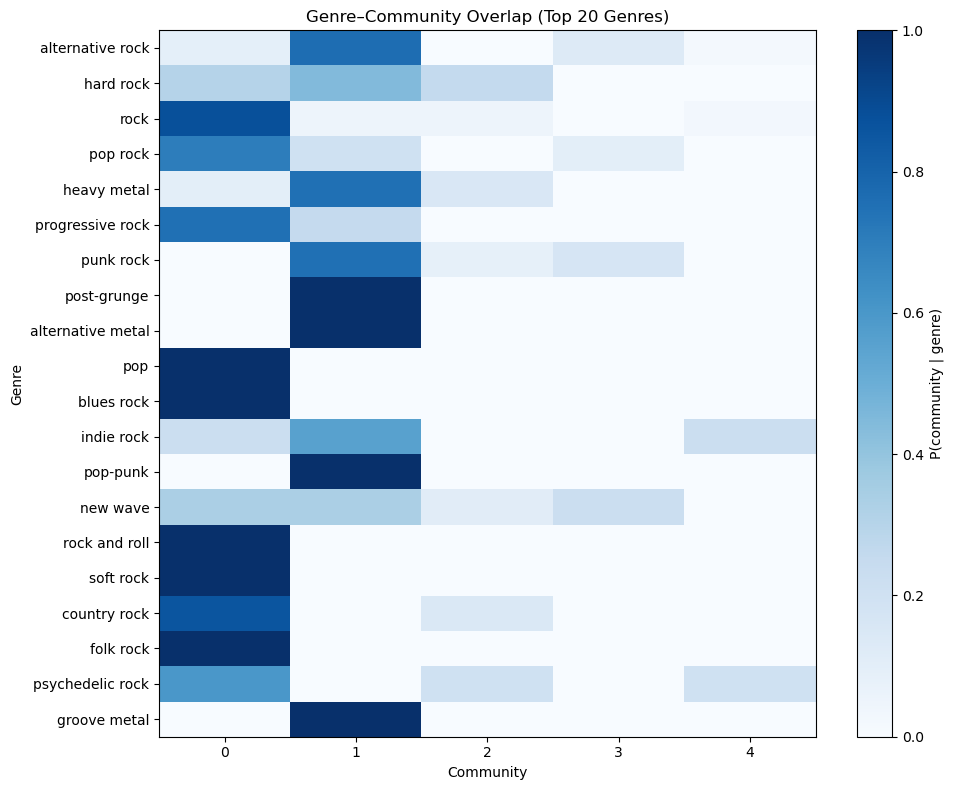

In [10]:
# Ensure that the working graph (H) has both attributes
H_nodes = [n for n, d in H.nodes(data=True) if "genre_primary" in d and "community" in d]

# Build a DataFrame: one row per artist with genre + community
rows = []
for n in H_nodes:
    g = H.nodes[n]["genre_primary"]
    c = H.nodes[n]["community"]
    rows.append((g, c))

df = pd.DataFrame(rows, columns=["genre", "community"])

# Count artists per (genre, community) pair
D = pd.crosstab(df["genre"], df["community"])

# Normalize rows → P(community | genre)
D_row_norm = D.div(D.sum(axis=1).replace(0, np.nan), axis=0)

# Basic summary
print(f"Matrix D shape: {D.shape[0]} genres × {D.shape[1]} communities")
display(D.head(10))

# Select top 20 genres by total artist count
genre_counts = D.sum(axis=1).sort_values(ascending=False)
top_genres = genre_counts.head(20).index
D_top = D_row_norm.loc[top_genres]

# Plot heatmap
plt.figure(figsize=(10, 8))
plt.imshow(D_top, aspect="auto", cmap="Blues")
plt.xticks(ticks=range(D_top.shape[1]), labels=D_top.columns)
plt.yticks(ticks=range(len(D_top.index)), labels=D_top.index)
plt.colorbar(label="P(community | genre)")
plt.title("Genre–Community Overlap (Top 20 Genres)")
plt.xlabel("Community")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()


The matrix shows how genres are distributed across the five detected communities. Most genres are concentrated in one main community, but several (like alternative rock, hard rock, and pop rock) appear in multiple communities. This means that while some stylistic clusters exist, artists often connect across genre boundaries.

Overall, the overlap suggests that the community structure captures more than just musical style and it likely reflects collaboration links, time periods, or shared influences beyond genre labels.

We can now try to visualise the communities to analyse them further

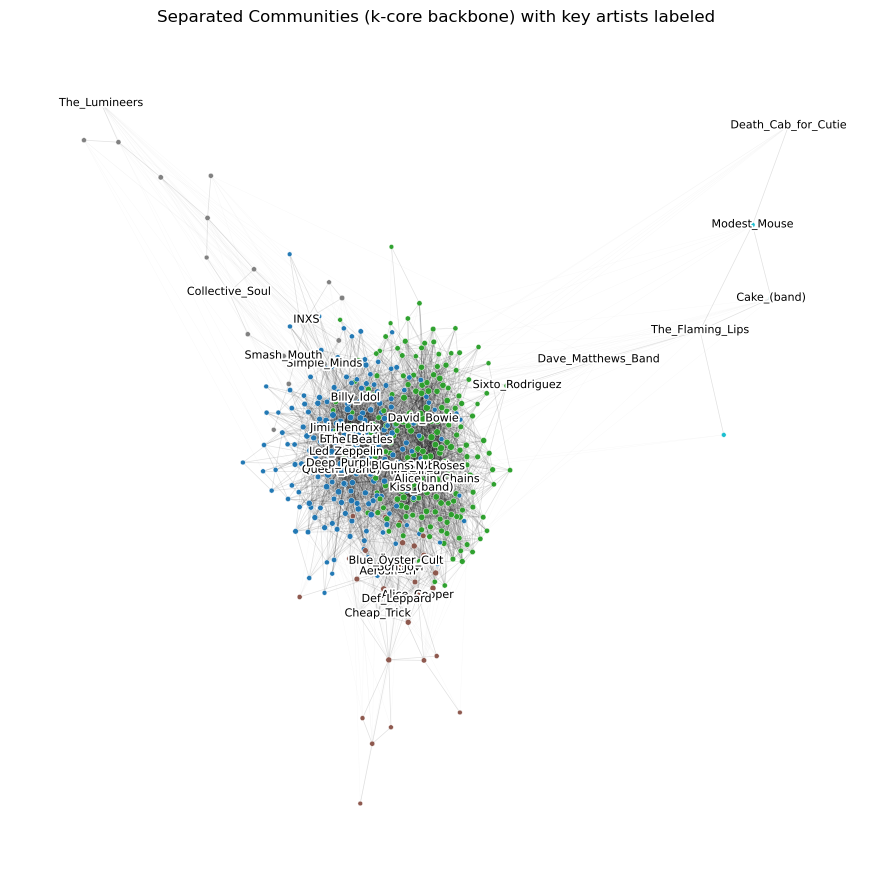

In [11]:
K_CORE = 3                 # use a backbone to reduce clutter
TOP_N_PER_COMM = 6         # label this many top-degree nodes per community
COMMUNITY_GAP = 4.0        # distance between community centers (bigger -> more separation)
SUBGRAPH_SCALE = 1.0       # relative size of each community bubble
SEED = 42

try:
    H_core = nx.k_core(H, k=K_CORE)
    if H_core.number_of_nodes() == 0:
        H_core = H.copy()
except nx.NetworkXError:
    H_core = H.copy()

comm_attr = nx.get_node_attributes(H_core, "community")
comm_nodes = defaultdict(list)
for n, cid in comm_attr.items():
    comm_nodes[cid].append(n)

C = nx.Graph()
for cid in comm_nodes.keys():
    C.add_node(cid, size=len(comm_nodes[cid]))

for u, v in H_core.edges():
    cu, cv = comm_attr[u], comm_attr[v]
    if cu == cv: 
        continue
    if C.has_edge(cu, cv):
        C[cu][cv]['weight'] += 1
    else:
        C.add_edge(cu, cv, weight=1)

random.seed(SEED)
posC = nx.spring_layout(C, seed=SEED, k=COMMUNITY_GAP)

pos = {}
for cid, nodes in comm_nodes.items():
    SG = H_core.subgraph(nodes)
    # local layout (spring inside the bubble)
    local = nx.spring_layout(SG, seed=SEED, k=1 / math.sqrt(max(1, SG.number_of_nodes())))
    # normalize & scale local coords to a compact circle
    xs = [p[0] for p in local.values()]
    ys = [p[1] for p in local.values()]
    w = (max(xs) - min(xs)) or 1.0
    h = (max(ys) - min(ys)) or 1.0
    s = SUBGRAPH_SCALE / max(w, h)

    cx, cy = posC[cid]
    for n, (x, y) in local.items():
        pos[n] = (cx + s * (x - sum(xs)/len(xs)), cy + s * (y - sum(ys)/len(ys)))

deg = dict(H_core.degree())
labels = {}
for cid, nodes in comm_nodes.items():
    nodes_sorted = sorted(nodes, key=lambda n: deg.get(n, 0), reverse=True)
    for n in nodes_sorted[:TOP_N_PER_COMM]:
        labels[n] = n

plt.figure(figsize=(11, 11))

intra_edges, inter_edges = [], []
for u, v in H_core.edges():
    (intra_edges if comm_attr[u] == comm_attr[v] else inter_edges).append((u, v))

nx.draw_networkx_edges(H_core, pos, edgelist=inter_edges, alpha=0.03, width=0.3)  # faint
nx.draw_networkx_edges(H_core, pos, edgelist=intra_edges, alpha=0.12, width=0.5)  # stronger

# nodes colored by community, size by sqrt(degree)
node_colors = [comm_attr[n] for n in H_core.nodes()]
node_sizes = [8 + 2*math.sqrt(deg[n]) for n in H_core.nodes()]
nx.draw_networkx_nodes(
    H_core, pos,
    node_color=node_colors, cmap="tab10",
    node_size=node_sizes,
    linewidths=0.3, edgecolors="white", alpha=0.98
)

# labels with white halo for readability
text_objs = nx.draw_networkx_labels(H_core, pos, labels=labels, font_size=8)
for t in text_objs.values():
    t.set_path_effects([pe.Stroke(linewidth=2.5, foreground="white"), pe.Normal()])

plt.title("Separated Communities (k-core backbone) with key artists labeled")
plt.axis("off")
plt.show()


The blue and green communities form one large interconnected cluster because they mostly include rock-related artists that share many links across genres like classic rock, hard rock, and alternative rock. These styles overlap heavily, so the network layout pulls them close together instead of separating them clearly.

In contrast, the other three smaller communities are more distinct and sit farther away. They likely represent artists or genres with fewer connections to the main rock scene such as more modern, indie, or niche styles which makes them form tighter, more isolated groups in the network.

This fits well with the rest of the analysis. Earlier, we found that the modularity (Q = 0.268) showed only moderate community structure and that genres alone had a much lower modularity (Q = 0.063). The visualization supports this: even though there are distinct communities, many artists especially those in the large rock-related cluster connect across genre boundaries. The smaller, separate groups match the few clearer clusters we found. Overall, the network shows some structure, but artists often connect across genres.

## Part 3

TF-IDF stands for Term Frequency-Inverse Document Frequency. It’s a way to measure how important a word is within a context, like a document or a set of documents.
The first part, Term Frequency (TF), looks at how often a word appears in a specific document. The more times it shows up, the more important it might be.
The second part, Inverse Document Frequency (IDF), looks at how common or rare a word is across all documents. If a word appears in many documents, it’s probably not very special. But if it only shows up in a few, it might be more important in the specific context.

In this project, each artist's wikipedia text file can be seen as a "document", and the TF-IDF helps us find words that are particularly significant for each artist compared to others. By calculating TF-IDF scores for words in these files, we can identify terms that describe or are closely associated with each artist, filtering out common words that don't add much value.

In the next snippet we can generate the TF-IDF matrix for the top genres to see which words are most characteristic for each genre.

=== TF-IDF by Genre (Top 5) ===


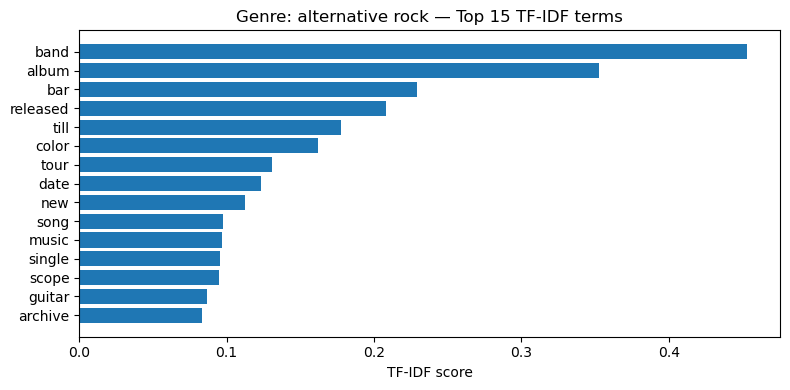

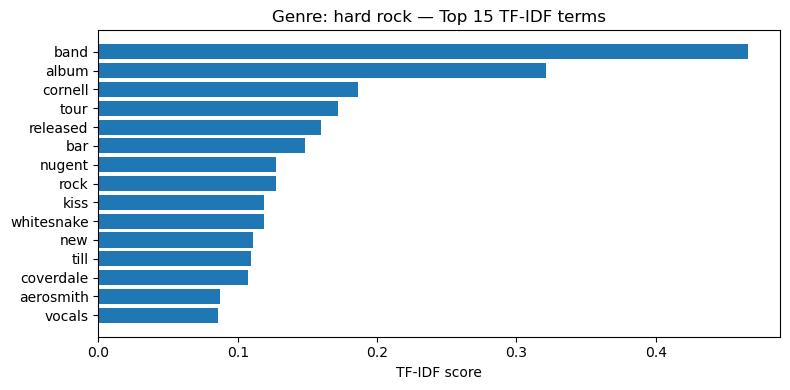

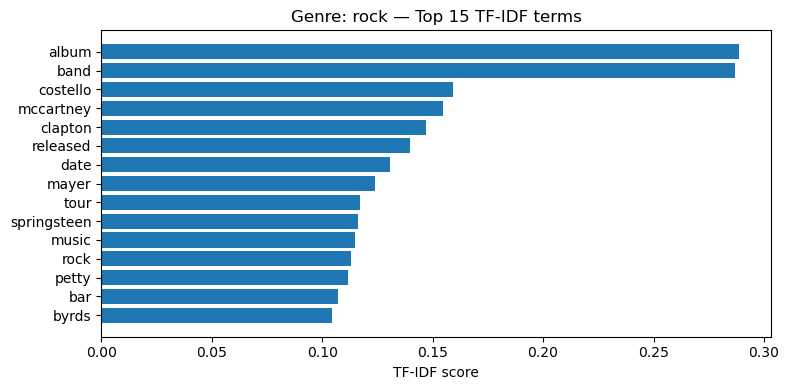

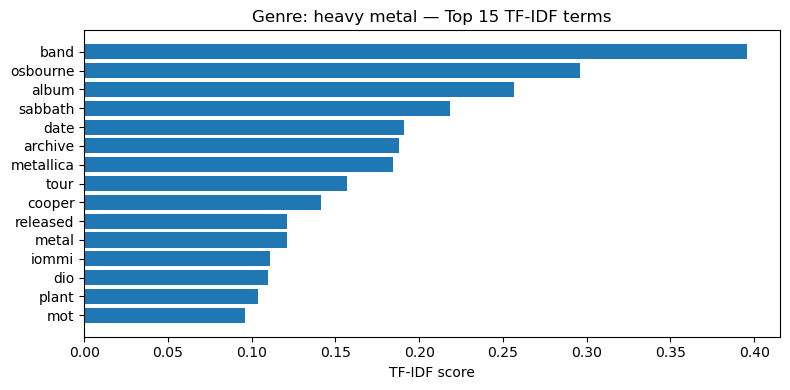

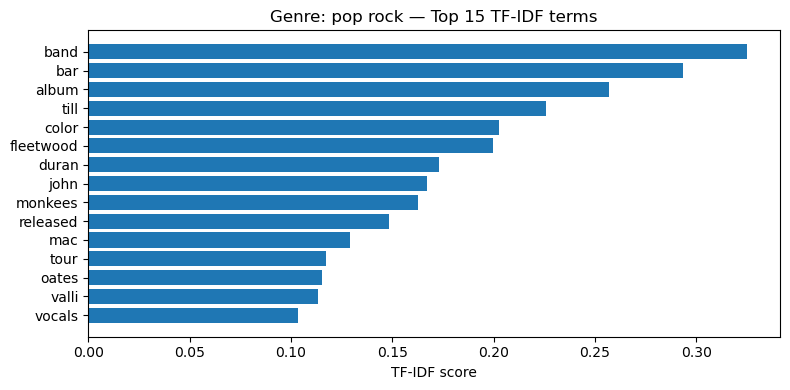

In [12]:

# -------- Helper: clean and load artist texts --------
def clean_text(text: str) -> str:
    """Remove URLs, markup, HTML tags, refs, and punctuation noise."""
    text = text.lower()
    # remove URLs and www
    text = re.sub(r"http\S+|www\.\S+", " ", text)
    # remove wiki markup [[...]] and templates {{...}}
    text = re.sub(r"\{\{.*?\}\}", " ", text)
    text = re.sub(r"\[\[.*?\]\]", " ", text)
    # remove HTML tags
    text = re.sub(r"<.*?>", " ", text)
    # remove numbers and non-letter chars
    text = re.sub(r"[^a-z\s]", " ", text)
    # collapse whitespace
    text = re.sub(r"\s+", " ", text)
    return text.strip()

def load_cleaned_artist_texts(G, artist_dir="artists"):
    texts = {}
    for n in G.nodes:
        path = os.path.join(artist_dir, f"{n}.txt")
        if os.path.isfile(path):
            with open(path, "r", encoding="utf-8") as f:
                txt = f.read()
                texts[n] = clean_text(txt)
    return texts

artist_texts = load_cleaned_artist_texts(G_genre, artist_dir=artist_dir)

# -------- Combine texts by genre and community --------
texts_by_genre = defaultdict(list)
texts_by_comm = defaultdict(list)

for n, data in G_genre.nodes(data=True):
    g = data.get("genre_primary")
    c = data.get("community")
    txt = artist_texts.get(n, "")
    if g:
        texts_by_genre[g].append(txt)
    if c is not None:
        texts_by_comm[c].append(txt)

genre_docs = {g: " ".join(tlist) for g, tlist in texts_by_genre.items()}
comm_docs  = {c: " ".join(tlist) for c, tlist in texts_by_comm.items()}

# -------- TF-IDF function --------
def tfidf_top_terms(doc_dict, top_n=15, top_k_groups=None, title_prefix=""):
    """Compute TF-IDF and plot top terms for selected groups."""
    labels = list(doc_dict.keys())
    corpus = list(doc_dict.values())

    # extra stopwords to remove junk tokens
    extra_stop = {"ref", "http", "https", "www", "com", "org", "url", "cite", "retrieved"}
    vectorizer = TfidfVectorizer(stop_words="english", max_features=5000)
    X = vectorizer.fit_transform(corpus)
    terms = np.array(vectorizer.get_feature_names_out())

    # remove columns that are just junk
    good_cols = [i for i, t in enumerate(terms) if t not in extra_stop]
    X = X[:, good_cols]
    terms = terms[good_cols]

    tfidf_df = pd.DataFrame(X.toarray(), index=labels, columns=terms)

    # select groups to visualize (top_k_groups by text length or manually)
    if top_k_groups:
        plot_labels = top_k_groups
    else:
        lengths = {label: len(doc_dict[label]) for label in labels}
        plot_labels = sorted(lengths, key=lengths.get, reverse=True)[:5]  # default: top 5

    for label in plot_labels:
        row = tfidf_df.loc[label]
        top_terms = row.sort_values(ascending=False).head(top_n)
        plt.figure(figsize=(8, 4))
        plt.barh(top_terms.index[::-1], top_terms.values[::-1])
        plt.title(f"{title_prefix}{label} — Top {top_n} TF-IDF terms")
        plt.xlabel("TF-IDF score")
        plt.tight_layout()
        plt.show()

    return tfidf_df

# -------- TF-IDF for top 5 genres --------
print("=== TF-IDF by Genre (Top 5) ===")
# find top 5 genres by number of artists
top_genres = sorted(texts_by_genre, key=lambda g: len(texts_by_genre[g]), reverse=True)[:5]
tfidf_genre_df = tfidf_top_terms(genre_docs, top_n=15, top_k_groups=top_genres, title_prefix="Genre: ")

We can also do the same for the communities detected earlier to see whuch words are most characteristic for each community. Having these as well as the TF-IDF for the top genres can give us additional info about the artist network.



=== TF-IDF by Community (Top 5) ===


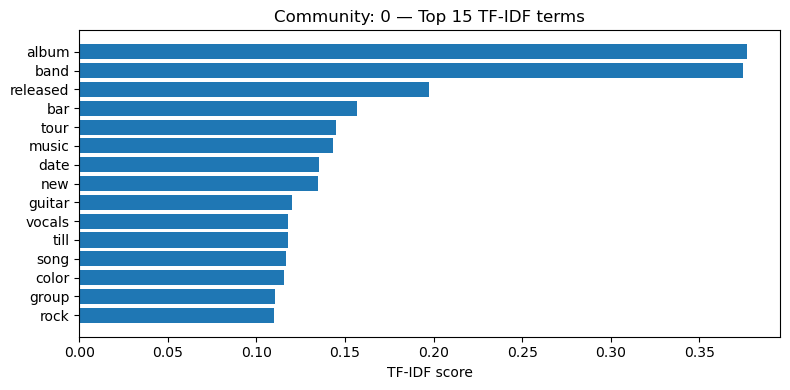

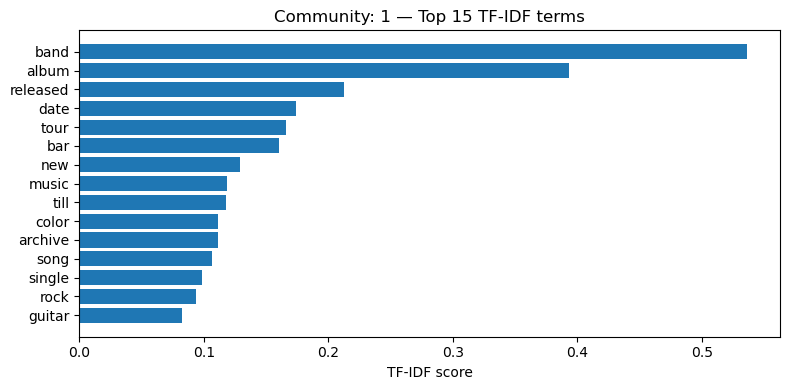

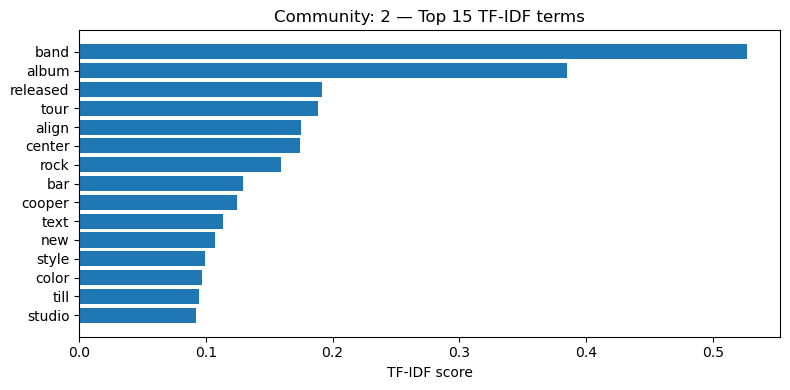

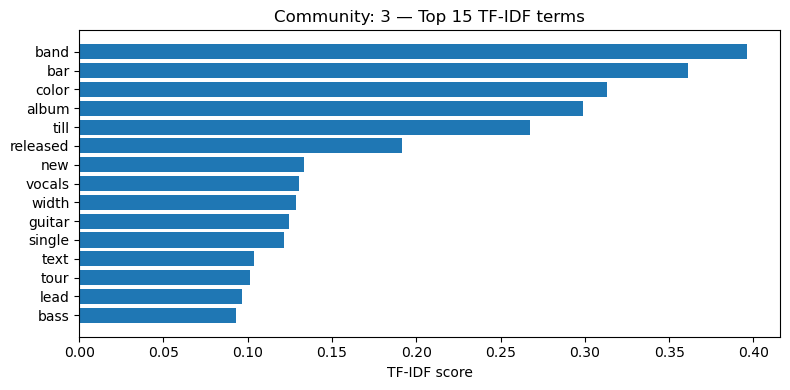

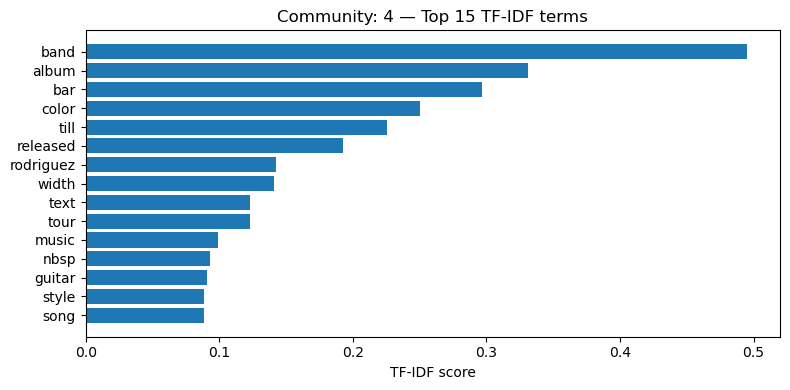

In [13]:
# -------- TF-IDF for top 5 communities --------
print("\n=== TF-IDF by Community (Top 5) ===")

# safety: ensure we actually have community labels and non-empty docs
if any(("community" not in d) for _, d in G_genre.nodes(data=True)):
    raise RuntimeError("No 'community' attribute on some nodes. Run the community detection cell and copy labels to G_genre first.")

# filter out empty community documents (after cleaning/merge)
comm_docs_nonempty = {c: doc for c, doc in comm_docs.items() if doc.strip()}
if not comm_docs_nonempty:
    raise RuntimeError("All community documents are empty after cleaning. Check your cleaning or community labels.")

# pick top 5 communities by number of artists (that also have nonempty docs)
counts_by_comm = {c: len(texts_by_comm[c]) for c in comm_docs_nonempty.keys()}
top_communities = sorted(counts_by_comm, key=counts_by_comm.get, reverse=True)[:5]

tfidf_comm_df = tfidf_top_terms(
    comm_docs_nonempty,
    top_n=15,
    top_k_groups=top_communities,
    title_prefix="Community: "
)

The TF-IDF terms for the top genres mostly contain production-related words such as band, album, tour, released, and song. These are broad and common across many artists, showing that genre pages share a lot of general vocabulary rather than unique, genre-specific terminology. A few distinct names (like Osbourne, Sabbath, Fleetwood) reflect iconic figures that define genre.

When looking at the communities, the top TF-IDF words are very similar, again centered around band, album, tour, and music. This suggests that the communities capture the same kind of artist-to-artist connections seen within the artist network.

Overall, the TF-IDF analysis confirms what the modularity and network plots already showed: the network is strongly interconnected around common rock-related language and themes, while smaller, separate communities may correspond to stylistic or era-based subgroups rather than entirely different parts of the music world.

The TF-IDF results already show that both genres and communities share many of the same key words, which confirms that most genres are spread across multiple communities, leading to overlapping language, which is what we saw earlier with the D matrix.

To visualize this overlap more intuitively, we can also generate word clouds. We will only generate one for the top genre and one for the first community, since the word clouds serve the same purpose as the TF-IDF tables but in a more visual way.

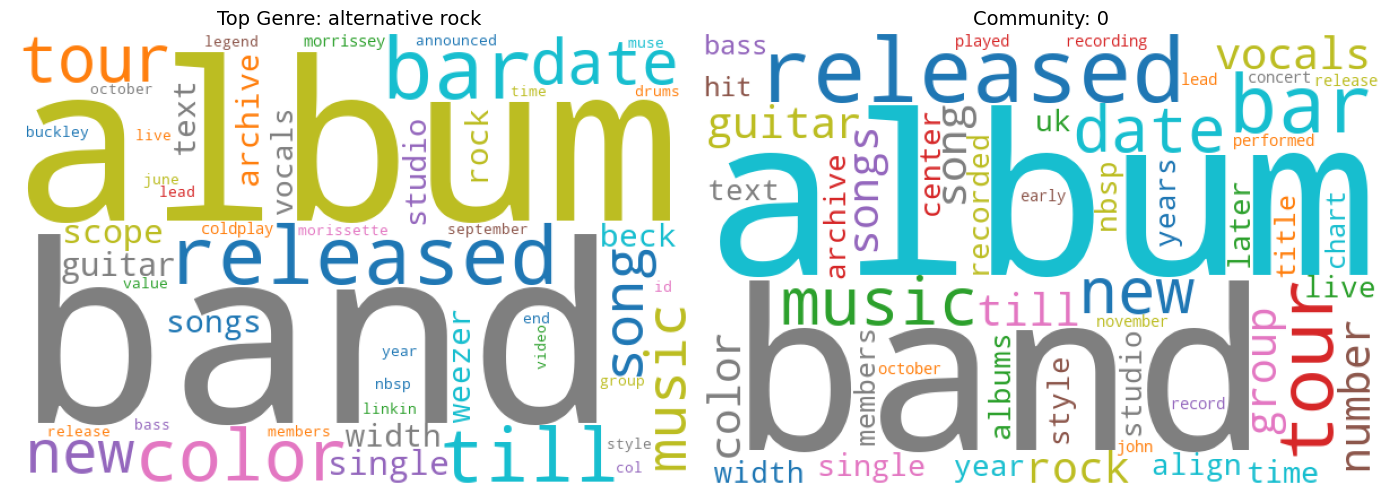

In [14]:
# pick the top genre (the first in your top_genres list)
top_genre = top_genres[0]
genre_terms = tfidf_genre_df.loc[top_genre].sort_values(ascending=False).head(50)

# pick the first community (the first in your top_communities list)
top_comm = top_communities[0]
comm_terms = tfidf_comm_df.loc[top_comm].sort_values(ascending=False).head(50)

# create and plot the word clouds
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
wc_genre = WordCloud(width=600, height=400, background_color="white", colormap="tab10")
plt.imshow(wc_genre.generate_from_frequencies(genre_terms.to_dict()))
plt.axis("off")
plt.title(f"Top Genre: {top_genre}", fontsize=14)

plt.subplot(1, 2, 2)
wc_comm = WordCloud(width=600, height=400, background_color="white", colormap="tab10")
plt.imshow(wc_comm.generate_from_frequencies(comm_terms.to_dict()))
plt.axis("off")
plt.title(f"Community: {top_comm}", fontsize=14)

plt.tight_layout()
plt.show()


These word clouds highlight what we already saw from the matrix D and the TF-IDF charts, which is that there is significant overlap in the language used across genres and communities.


## Part 4

Calculate the sentiment of the band/artist pages (it is OK to work with the sub-network of artists-with-genre) and describe your findings using stats and visualization, inspired by the first exercise of week 8

In [15]:


def load_labmt_lexicon(path: str) -> Dict[str, float]:
    lex: Dict[str, float] = {}
    with open(path, encoding="utf-8") as f:
        reader = csv.reader(f, delimiter="\t")
        header: Optional[Tuple[str, ...]] = None
        for row in reader:
            if not row or len(row) < 2:
                continue
            if header is None and row[0].strip().lower() == "word":
                header = tuple(col.strip().lower() for col in row)
                try:
                    w_idx = header.index("word")
                    h_idx = header.index("happiness_average")
                except ValueError:
                    raise ValueError("Missing 'word' or 'happiness_average' columns.")
                continue
            if header is None:
                continue
            try:
                word = row[w_idx].strip().lower()
                happiness = float(row[h_idx])
                if word:
                    lex[word] = happiness
            except Exception:
                continue
    if not lex:
        raise ValueError("No LabMT entries loaded—check the file path/format.")
    return lex

def labmt_average(tokens: Iterable[str], lexicon: Dict[str, float], neutral_min: float = 4.0, neutral_max: float = 6.0) -> Dict[str, float]:

    total = 0
    matched_scores = []
    n_neutral = 0

    for tok in tokens:
        total += 1
        score = lexicon.get(tok.lower())
        if score is not None:
            # Skip neutral-scored words
            if neutral_min <= score <= neutral_max:
                n_neutral += 1
                continue
            matched_scores.append(score)

    matched = len(matched_scores)
    score = (sum(matched_scores) / matched) if matched else float("nan")

    coverage = (matched / total) if total else 0.0

    return {
        "score": score,
        "n_total_tokens": total,
        "n_matched": matched,
        "n_neutral": n_neutral,
        "coverage": coverage,
    }


In [16]:
# Load the LabMT lexicon into the global variable `lex`

# Path to the LabMT data file (in the same folder as this notebook)
labmt_path = "labMT.txt"

if not os.path.isfile(labmt_path):
    raise FileNotFoundError(f'LabMT file not found at: {labmt_path}')

lex = load_labmt_lexicon(labmt_path)
print(f'Loaded LabMT lexicon from {labmt_path} with {len(lex)} entries.')

Loaded LabMT lexicon from labMT.txt with 10222 entries.


In [17]:

# Undirected projection for algorithms that need it
G_undirected = G_clean.to_undirected()

# Compute and attach length_of_content to graphs
length_of_content = {}
for filename in artist_files:
    filepath = os.path.join(artist_dir, filename)
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            text = f.read()
    except Exception:
        text = ''
    node_name = os.path.splitext(filename)[0]
    length_of_content[node_name] = len(text)

nx.set_node_attributes(G_clean, {n: length_of_content.get(n, 0) for n in G_clean.nodes()}, 'length_of_content')
nx.set_node_attributes(G_undirected, {n: length_of_content.get(n, 0) for n in G_undirected.nodes()}, 'length_of_content')

print(f"Cleaned directed graph: {G_clean.number_of_nodes()} nodes, {G_clean.number_of_edges()} edges")
print(f"Undirected projection: {G_undirected.number_of_nodes()} nodes, {G_undirected.number_of_edges()} edges")

# sentiment per page over the cleaned network
def tokenize_wikitext(text: str):
    
    text = re.sub(r"\[\[(?:[^|\]]+\|)?([^\]]+)\]\]", r"\1", text)
    
    text = re.sub(r"\{\{.*?\}\}", " ", text, flags=re.DOTALL)
    text = re.sub(r"<ref[^>]*>.*?</ref>", " ", text, flags=re.DOTALL)
    
    text = re.sub(r"</?[^>]+>", " ", text)  
    text = re.sub(r"[^\w\s']", " ", text)   
    tokens = re.findall(r"[A-Za-z]+", text.lower())
    return tokens


sentiment_by_node = {}
csv_rows = []

for node in G_clean.nodes():
    filepath = os.path.join(artist_dir, f"{node}.txt")
    try:
        with open(filepath, "r", encoding="utf-8") as f:
            page_text = f.read()
    except Exception:
        page_text = ""

    tokens = tokenize_wikitext(page_text)
    stats = labmt_average(tokens, lex)  # {"score", "n_total_tokens", "n_matched", "coverage"}
    sentiment_by_node[node] = stats

    csv_rows.append({
        "artist": node,
        "labmt_score": stats["score"],
        "n_total_tokens": stats["n_total_tokens"],
        "n_matched": stats["n_matched"],
        "coverage": stats["coverage"],
        "length_of_content": length_of_content.get(node, 0),
    })


nx.set_node_attributes(G_clean, {n: d["score"] for n, d in sentiment_by_node.items()}, "labmt_score")
nx.set_node_attributes(G_clean, {n: d["n_total_tokens"] for n, d in sentiment_by_node.items()}, "labmt_n_total_tokens")
nx.set_node_attributes(G_clean, {n: d["n_matched"] for n, d in sentiment_by_node.items()}, "labmt_n_matched")
nx.set_node_attributes(G_clean, {n: d["coverage"] for n, d in sentiment_by_node.items()}, "labmt_coverage")


nx.set_node_attributes(G_undirected, {n: sentiment_by_node[n]["score"] for n in G_undirected.nodes() if n in sentiment_by_node}, "labmt_score")
nx.set_node_attributes(G_undirected, {n: sentiment_by_node[n]["n_total_tokens"] for n in G_undirected.nodes() if n in sentiment_by_node}, "labmt_n_total_tokens")
nx.set_node_attributes(G_undirected, {n: sentiment_by_node[n]["n_matched"] for n in G_undirected.nodes() if n in sentiment_by_node}, "labmt_n_matched")
nx.set_node_attributes(G_undirected, {n: sentiment_by_node[n]["coverage"] for n in G_undirected.nodes() if n in sentiment_by_node}, "labmt_coverage")

# Persist results as a CSV
out_csv = "artist_labmt_sentiment.csv"
with open(out_csv, "w", encoding="utf-8", newline="") as f:
    writer = csv.DictWriter(
        f,
        fieldnames=["artist", "labmt_score", "n_total_tokens", "n_matched", "coverage", "length_of_content"],
    )
    writer.writeheader()
    writer.writerows(csv_rows)

print(f"Wrote per-page LabMT sentiment to {out_csv}.")


Cleaned directed graph: 484 nodes, 7323 edges
Undirected projection: 484 nodes, 6021 edges
Wrote per-page LabMT sentiment to artist_labmt_sentiment.csv.


The above code uses regex to clean up the wikitext, into nice tokens. 
The above code creates a csv file, that contains all the important information needed to do good analysis on the sentiment. Most importantly, it contains a row with the average sentiment, for every artist. 

In [18]:
#  Aggregate sentiment statistics across all pages
all_scores = [
    stats["score"] for stats in sentiment_by_node.values()
    if not math.isnan(stats["score"])
]

if all_scores:
    avg_sentiment = np.mean(all_scores)
    median_sentiment = np.median(all_scores)
    variance_sentiment = np.var(all_scores)
    q25 = np.percentile(all_scores, 25)
    q75 = np.percentile(all_scores, 75)

    print("\n--- Global Sentiment Stats ---")
    print(f"Average sentiment:  {avg_sentiment:.3f}")
    print(f"Median sentiment:   {median_sentiment:.3f}")
    print(f"Variance:           {variance_sentiment:.5f}")
    print(f"25th percentile:    {q25:.3f}")
    print(f"75th percentile:    {q75:.3f}")
else:
    print("No valid sentiment scores found (all NaN).")


--- Global Sentiment Stats ---
Average sentiment:  6.298
Median sentiment:   6.320
Variance:           0.02815
25th percentile:    6.234
75th percentile:    6.385


Description of Key stats across our dataset.

The sentiment scores stay in a tight range. Most profiles fall between 6.234 and 6.385. The median is 6.320, the average is 6.298, and the variance is 0.02815. That means there isn’t much spread and the tone is consistent.

Overall, the tone is slightly positive. Neutral, wikipedia writing that lists concrete accomplishments tends to use achievement and recognition words. That pushes scores a bit above neutral, which is most likely why most sit just over 6.

Differences from page to page are small. The median is close to the mean, which points to a roughly symmetric distribution centered just above neutral. The 25th and 75th percentiles are close together, so the interquartile range is narrow and variation is limited.

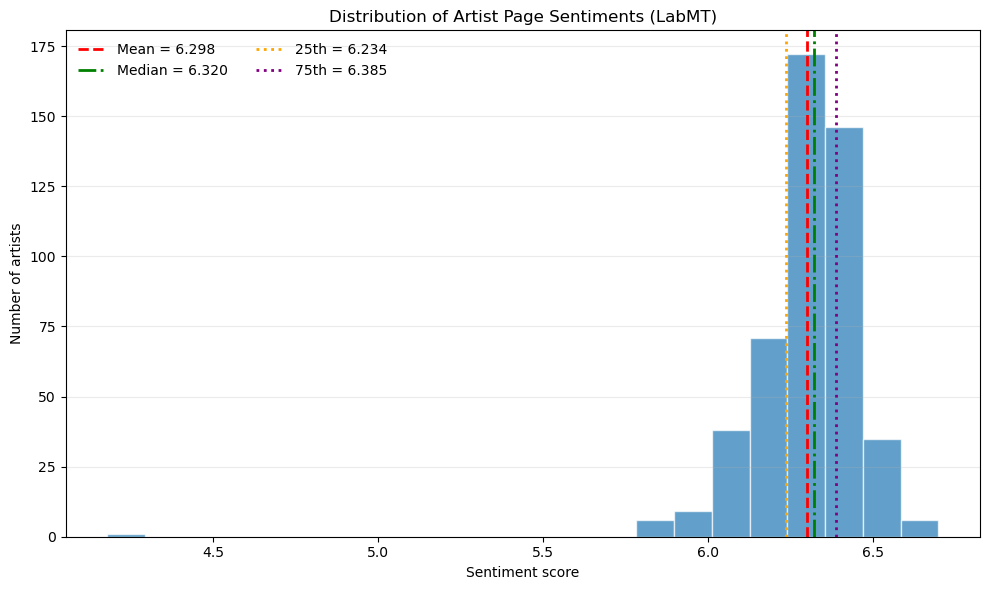

In [19]:
if 'all_scores' not in globals() or not all_scores:
    print('No scores to plot.')
else:
    
    bins = max(10, int(np.sqrt(len(all_scores))))
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.hist(all_scores, bins=bins, density=False, alpha=0.7, edgecolor='white')

    # Distinct colored reference lines
    ax.axvline(avg_sentiment, color='red', linestyle='--', linewidth=2, label=f"Mean = {avg_sentiment:.3f}")
    ax.axvline(median_sentiment, color='green', linestyle='-.', linewidth=2, label=f"Median = {median_sentiment:.3f}")
    ax.axvline(q25, color='orange', linestyle=':', linewidth=2, label=f"25th = {q25:.3f}")
    ax.axvline(q75, color='purple', linestyle=':', linewidth=2, label=f"75th = {q75:.3f}")

    # Labels & title
    ax.set_title('Distribution of Artist Page Sentiments (LabMT)')
    ax.set_xlabel('Sentiment score')
    ax.set_ylabel('Number of artists')

    # Grid and legend
    ax.grid(axis='y', alpha=0.25)
    ax.legend(frameon=False, ncol=2)

    

    plt.tight_layout()
    plt.show()

The histogram shows the distribution of average LabMT sentiment scores after removing neutral words (4–6). Scores cluster tightly just above 6, with a mean of 6.298 and a median of 6.320, suggesting a roughly symmetric shape with a slight left skew. The interquartile range is narrow (6.234 to 6.385), so most pages have very similar, slightly positive sentiment. There’s a small left tail with a low outlier, which pulls the mean a bit below the median.


In [20]:
#  Top 10 happiest and saddest artist pages

valid_scores = {
    artist: stats["score"]
    for artist, stats in sentiment_by_node.items()
    if not math.isnan(stats["score"])
}

sorted_artists = sorted(valid_scores.items(), key=lambda x: x[1])


print("\n10 Saddest Artist Pages:")
for i, (artist, score) in enumerate(sorted_artists[:10], start=1):
    print(f"{i:2d}. {artist:25s}  score = {score:.3f}")

print("\n10 Happiest Artist Pages:")
for i, (artist, score) in enumerate(sorted_artists[-10:], start=1):
    print(f"{i:2d}. {artist:25s}  score = {score:.3f}")



10 Saddest Artist Pages:
 1. Poison_(American_band)     score = 4.180
 2. Gary_Glitter               score = 5.805
 3. Rob_Zombie                 score = 5.806
 4. Rage_Against_the_Machine   score = 5.814
 5. Five_Finger_Death_Punch    score = 5.850
 6. Marilyn_Manson             score = 5.869
 7. White_Zombie_(band)        score = 5.881
 8. Bad_Company                score = 5.908
 9. Ted_Nugent                 score = 5.928
10. Meat_Loaf                  score = 5.940

10 Happiest Artist Pages:
 1. Counting_Crows             score = 6.556
 2. Vampire_Weekend            score = 6.559
 3. Air_Supply                 score = 6.563
 4. Dallas_Green_(musician)    score = 6.580
 5. Fun_(band)                 score = 6.590
 6. Ten_Years_After            score = 6.594
 7. Tracy_Chapman              score = 6.596
 8. Michael_Martin_Murphey     score = 6.600
 9. Lenny_Kravitz              score = 6.617
10. The_Boxtones               score = 6.697


The sentiment results show a slight genre-related trend. Artists with lower sentiment scores, such as Rage Against the Machine and Marilyn Manson, are primarily associated with harder or more aggressive genres like metal and punk, which often include darker or more conflict-oriented language in their Wikipedia pages. In contrast, the artists with higher sentiment scores, such as Fun and Air Supply represent softer or more uplifting genres like pop and soft rock. This suggests that the emotional tone of the text surrounding these artists subtly reflects the general mood or themes of their music.

Furthermore, the results show, that there does not seem to be a lot of outliers, however one band, 'Poison_(American_band)' seems to need further investigation due to its score of 4.180. We will check that below

In [21]:

node = "Poison_(American_band)"

s = sentiment_by_node[node]
print(f"Sentiment summary for {node}:")
print(f"  labmt_score      = {s['score']:.3f}")
print(f"  n_total_tokens   = {s['n_total_tokens']}")
print(f"  n_matched        = {s['n_matched']}")
print(f"  n_neutral        = {s.get('n_neutral')}")
print(f"  coverage         = {s['coverage']:.3f}")
print(f"  length_of_content= {length_of_content[node]}")

filepath = os.path.join(artist_dir, f"{node}.txt")
with open(filepath, "r", encoding="utf-8") as f:
    text = f.read()

tokens = tokenize_wikitext(text)
matched_tokens = [tok for tok in tokens if tok.lower() in lex]

print("\nToken diagnostics:")
print(f"  total tokens    = {len(tokens)}")
print(f"  lexicon matches = {len(matched_tokens)} ")
print(matched_tokens)


Sentiment summary for Poison_(American_band):
  labmt_score      = 4.180
  n_total_tokens   = 3
  n_matched        = 2
  n_neutral        = 0
  coverage         = 0.667
  length_of_content= 74

Token diagnostics:
  total tokens    = 3
  lexicon matches = 2 
['poison', 'band']


As can be seen on the results above, the wikipedia data for this specific band, it not fit for data analysis, with only 3 total tokens recognized. We can therefore conclude, that this is not a case of an extremely 'sad' band, but a result of non-usable data, that should be removed if further data analysis was to be conducted. 



Community sentiment summary (top 10 by size):
Comm  0: n=216, mean=6.321, med=6.324, std=0.126
Comm  1: n=202, mean=6.273, med=6.302, std=0.143
Comm  2: n= 35, mean=6.317, med=6.312, std=0.155
Comm  3: n= 20, mean=6.355, med=6.378, std=0.087
Comm  4: n=  7, mean=6.332, med=6.358, std=0.104


/var/folders/rl/t5dv0yl50_v6ldwq8txtwk7h0000gn/T/ipykernel_12477/3837949054.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=labels, showmeans=True)


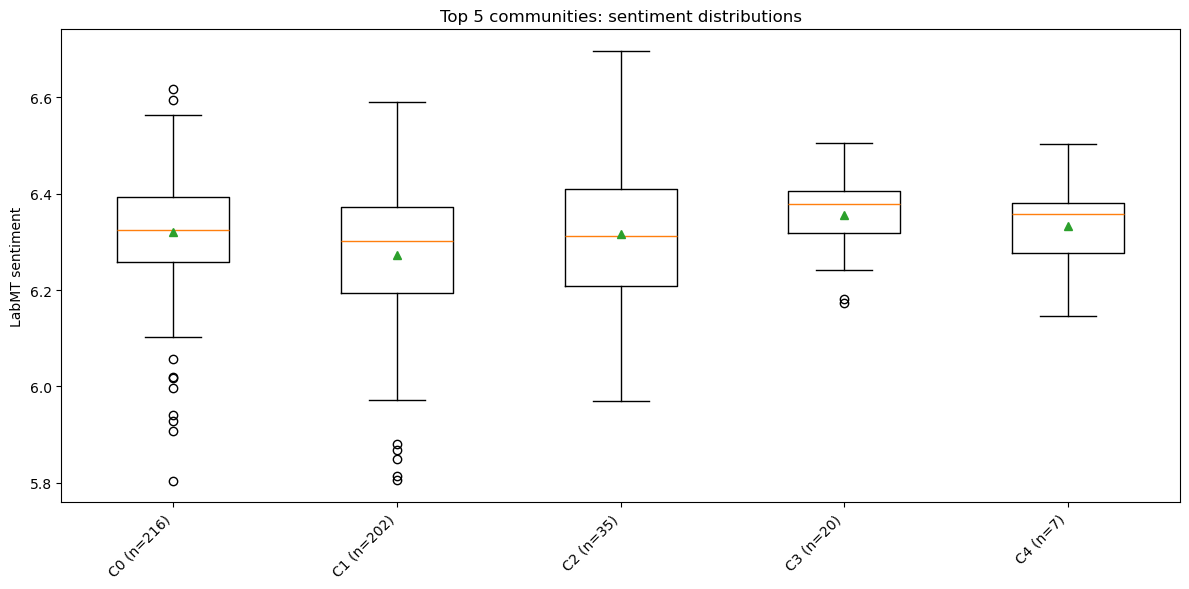

In [22]:
comm_nodes = defaultdict(list)
for n, d in G_genre.nodes(data=True):
    cid = d.get('community')
    if cid is None:
        continue
    comm_nodes[cid].append(n)

if not comm_nodes:
    print('No community labels found on G_genre.')
else:
    rows = []

    for cid, nodes in sorted(comm_nodes.items(), key=lambda x: -len(x[1])):
        scores = [sentiment_by_node.get(n, {}).get('score') for n in nodes]
        valid_scores = [s for s in scores if s is not None and not math.isnan(s)]
       
        mean_score = float(np.mean(valid_scores)) if valid_scores else float('nan')
        median_score = float(np.median(valid_scores)) if valid_scores else float('nan')
        std_score = float(np.std(valid_scores)) if valid_scores else float('nan')
        rows.append({
            'community': cid,
            'n_nodes': len(nodes),
            'mean_score': mean_score,
            'median_score': median_score,
            'std_score': std_score,
        })

    print('\nCommunity sentiment summary (top 10 by size):')
    for r in rows[:10]:
        print(f"Comm {r['community']:2d}: n={r['n_nodes']:3d}, mean={r['mean_score']:.3f}, med={r['median_score']:.3f}, std={r['std_score']:.3f}")

    # Prepare boxplot for top-K communities by size
    topk = 10
    top_comm = [cid for cid, nodes in sorted(comm_nodes.items(), key=lambda x: -len(x[1]))][:topk]
    data = []
    labels = []
    for cid in top_comm:
        vals = [sentiment_by_node.get(n, {}).get('score') for n in comm_nodes[cid]]
        vals = [v for v in vals if v is not None and not math.isnan(v)]
        data.append(vals if vals else [np.nan])
        labels.append(f"C{cid} (n={len(comm_nodes[cid])})")

    plt.figure(figsize=(12,6))
    plt.boxplot(data, labels=labels, showmeans=True)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('LabMT sentiment')
    plt.title(f'Top {len(labels)} communities: sentiment distributions')
    plt.tight_layout()
    plt.show()

    

The sentiment results show that all five main communities are remarkably similar, with mean values ranging narrowly from about 6.27 to 6.36 and low standard deviations around 0.1. This means there’s barely any difference in overall sentiment across groups, which matches what we found earlier in Part 3. Even though community sizes range from just 7 members up to over 200, their sentiment distributions are very simillar.

These results make sense when we look back at the TF-IDF findings. The top terms across both genres and communities were dominated by general, music-related words like band, album, tour, and song. Since these are common across many artists and not tied to specific genres or moods, its natural that sentiment stays consistent across communities. The overlap in language also shows that the communities arent defined by emotional tone but by shared musical context — mostly centered around common rock-related themes. So, the TF-IDF analysis helps explain why the sentiment differences are minimal: the communities are talking about the same kinds of things, just from slightly different corners of the same music space.

### Work distribution
We split the work into focus areas, but still worked together on most of the parts, since we work together during class. 
However most of the supplementary work for the assignment was split up like the following:\
**Part 1 was made mostly by Nicklas**\
**Part 2 was made mostly by Alexander**\
**Part 3 was made mostly by Alexander**\
**Part 4 was made mostly by Oliver**